In [257]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import os

In [258]:
local_tz = pytz.timezone("America/New_York")

In [259]:
file_path = "/Users/avborovets/Desktop/hackathon/unemployment.xlsx"

# Чтение файла Excel
data = pd.read_excel(file_path)

# Просмотр первых строк файла
print(len(data))

114


In [260]:
# Удаление текста в скобках
data['Дата выпуска'] = data['Дата выпуска'].str.replace(r'\s*\(.*\)', '', regex=True)

# Преобразование строки в datetime
data['Дата выпуска'] = pd.to_datetime(data['Дата выпуска'], format='%d.%m.%Y', errors='coerce')

# Проверка результата
data[:10]


,Дата выпуска,Время,Факт,Прогноз,Пред
0,2024-12-06,16:30:00,0.042,0.042,0.041
1,2024-11-01,15:30:00,0.041,0.041,0.041
2,2024-10-04,15:30:00,0.041,0.042,0.042
3,2024-09-06,15:30:00,0.042,0.042,0.043
4,2024-08-02,15:30:00,0.043,0.041,0.041
5,2024-07-05,15:30:00,0.041,0.040,0.040
6,2024-06-07,15:30:00,0.040,0.039,0.039
7,2024-05-03,15:30:00,0.039,0.038,0.038
8,2024-04-05,15:30:00,0.038,0.039,0.039
9,2024-03-08,16:30:00,0.039,0.037,0.037


In [262]:
def get_eth_hourly_prices(start_date, end_date):
    start_timestamp = int(pd.Timestamp(start_date).timestamp())
    end_timestamp = int(pd.Timestamp(end_date).timestamp())

    # url = "https://min-api.cryptocompare.com/data/v2/histohour"
    url = "http://localhost:8083/data/v2/histohour"
    params = {
        "fsym": "ETH",
        "tsym": "USD",
        "limit": 72,
        "toTs": end_timestamp
    }

    response = requests.get(url, params=params)
    data = response.json()

    if "Data" in data and "Data" in data["Data"]:
        hourly_data = pd.DataFrame(data["Data"]["Data"])
        hourly_data["time"] = pd.to_datetime(hourly_data["time"], unit="s")
        return hourly_data
    else:
        return pd.DataFrame()

def get_eth_minute_prices(start_date, end_date):
    """Получение минутных данных ETH."""
    start_timestamp = int(pd.Timestamp(start_date).timestamp())
    end_timestamp = int(pd.Timestamp(end_date).timestamp())

    # url = "https://min-api.cryptocompare.com/data/v2/histominute"
    url = "http://localhost:8083/data/v2/histominute"
    params = {
        "fsym": "ETH",
        "tsym": "USD",
        "limit": 720,  # Максимум 720 минут (12 часов)
        "toTs": end_timestamp
    }

    response = requests.get(url, params=params)
    data = response.json()

    if "Data" in data and "Data" in data["Data"]:
        minute_data = pd.DataFrame(data["Data"]["Data"])
        minute_data["time"] = pd.to_datetime(minute_data["time"], unit="s")
        return minute_data
    else:
        return pd.DataFrame()


def calculate_indicators(data):
    """Добавляет технические индикаторы к DataFrame."""
    # Bollinger Bands
    data['MA20'] = data['close'].rolling(window=20).mean()
    data['stddev'] = data['close'].rolling(window=20).std()
    data['UpperBB'] = data['MA20'] + (2 * data['stddev'])
    data['LowerBB'] = data['MA20'] - (2 * data['stddev'])
    
    # RSI
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # ATR
    data['H-L'] = data['high'] - data['low']
    data['H-C'] = abs(data['high'] - data['close'].shift(1))
    data['L-C'] = abs(data['low'] - data['close'].shift(1))
    data['TR'] = data[['H-L', 'H-C', 'L-C']].max(axis=1)
    data['ATR'] = data['TR'].rolling(window=14).mean()
    
    return data

def check_movement_signals(data):
    """Проверяет сигналы на одностороннее движение."""
    signals = []
    
    # Bollinger Bands breakout
    if data.iloc[-1]['close'] > data.iloc[-1]['UpperBB']:
        signals.append("Breakout above Upper Bollinger Band (Bullish)")
    elif data.iloc[-1]['close'] < data.iloc[-1]['LowerBB']:
        signals.append("Breakout below Lower Bollinger Band (Bearish)")
    
    # RSI overbought/oversold
    if data.iloc[-1]['RSI'] > 70:
        signals.append("RSI indicates overbought (Potential reversal or continuation)")
    elif data.iloc[-1]['RSI'] < 30:
        signals.append("RSI indicates oversold (Potential reversal or continuation)")
    
    # ATR volatility spike
    if data.iloc[-1]['ATR'] > data['ATR'].mean() * 1.5:
        signals.append("ATR indicates increased volatility")
    
    return signals



График сохранён: ethereum/eth_2024-12-06.png
График сохранён: ethereum/eth_2024-11-01.png


KeyboardInterrupt: 

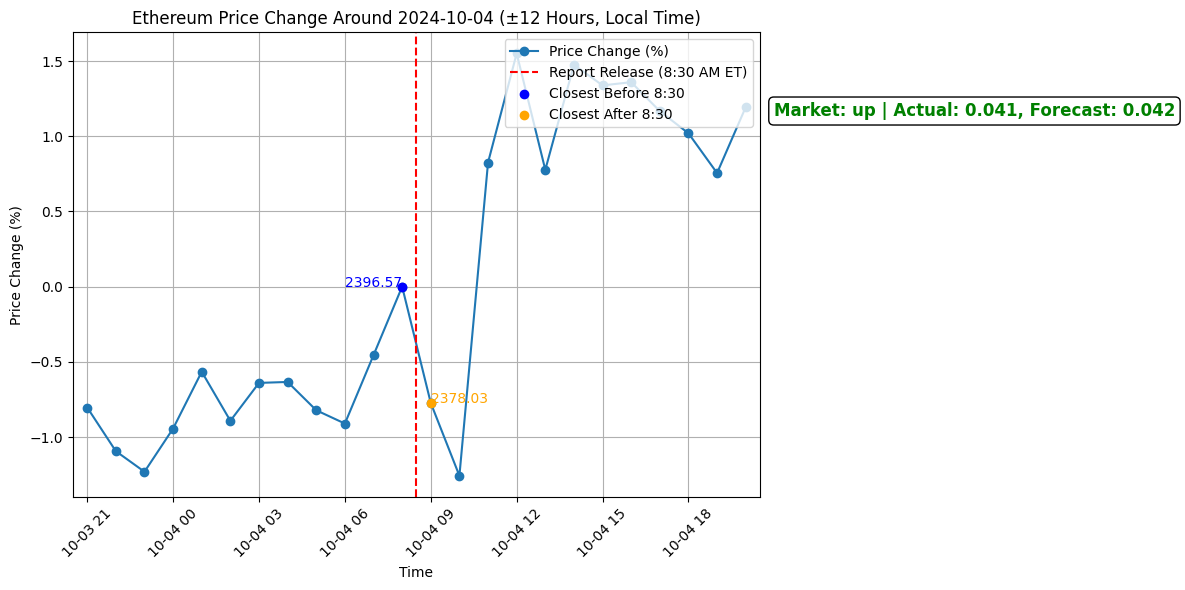

In [235]:
# OLD OLD OLD 
# Перебор строк таблицы data
for idx, row in data.iterrows():
    start_date = row['Дата выпуска'] - pd.Timedelta(days=1)
    end_date = row['Дата выпуска'] + pd.Timedelta(days=1)

    # Получение часовых цен ETH
    hourly_prices = get_eth_hourly_prices(start_date, end_date)

    if not hourly_prices.empty:
        # Преобразование времени в локальный часовой пояс
        hourly_prices["local_time"] = hourly_prices["time"].dt.tz_localize("UTC").dt.tz_convert(local_tz)

        # Время публикации отчета
        report_time = pd.Timestamp(row['Дата выпуска']).replace(hour=8, minute=30).tz_localize(local_tz)

        # Диапазон времени для графика (12 часов до и после публикации)
        start_limit = report_time - pd.Timedelta(hours=12)
        end_limit = report_time + pd.Timedelta(hours=12)

        # Фильтруем данные для отображения в пределах диапазона
        filtered_data = hourly_prices[
            (hourly_prices["local_time"] >= start_limit) &
            (hourly_prices["local_time"] <= end_limit)
        ]

        # Добавляем колонку с процентами отклонения
        filtered_data = filtered_data.copy()  # Создаем копию для предотвращения предупреждений
        filtered_data["percent_change"] = (filtered_data["close"] - base_price) / base_price * 100

        
        # Найти ближайшую точку до 8:30
        before_report_time = filtered_data[filtered_data["local_time"] <= report_time]
        if not before_report_time.empty:
            closest_before_idx = (report_time - before_report_time["local_time"]).idxmin()
            closest_before_point = before_report_time.loc[closest_before_idx]
            # Базовая цена для вычисления процентов
            base_price = closest_before_point["close"]
        else:
            closest_before_point = None
            base_price = None

        # Найти ближайшую точку после 8:30
        after_report_time = filtered_data[filtered_data["local_time"] > report_time]
        if not after_report_time.empty:
            closest_after_idx = (after_report_time["local_time"] - report_time).idxmin()
            closest_after_point = after_report_time.loc[closest_after_idx]
        else:
            closest_after_point = None

        if base_price is not None:
            # Добавляем колонку с процентами отклонения
            filtered_data["percent_change"] = (filtered_data["close"] - base_price) / base_price * 100

        # Извлечение фактического и прогнозного значения из строки
        actual = row['Факт']
        forecast = row['Прогноз']

        # Определение состояния рынка
        if actual < forecast:
            market_status = "up"
            color = "green"
            market_text = f"Market: {market_status} | Actual: {actual:.3f}, Forecast: {forecast:.3f}"
        elif actual == forecast:
            market_status = "same"
            color = "lightgreen"
            market_text = f"Market: {market_status} | Actual: {actual:.3f}, Forecast: {forecast:.3f}"
        else:
            market_status = "down"
            color = "red"
            market_text = f"Market: {market_status} | Actual: {actual:.3f}, Forecast: {forecast:.3f}"

        # Построение графика
        plt.figure(figsize=(12, 6))
        if base_price is not None:
            plt.plot(filtered_data["local_time"], filtered_data["percent_change"], marker='o', label="Price Change (%)")
        plt.axvline(report_time, color='red', linestyle='--', label="Report Release (8:30 AM ET)")

        # Отметка ближайшей точки до 8:30
        if closest_before_point is not None and base_price is not None:
            plt.scatter(
                closest_before_point["local_time"], 0, color="blue", label="Closest Before 8:30", zorder=5
            )
            plt.text(
                closest_before_point["local_time"], 0,
                f"{closest_before_point['close']:.2f}",
                fontsize=10, color="blue", ha="right"
            )

        # Отметка ближайшей точки после 8:30
        if closest_after_point is not None and base_price is not None:
            percent_change_after = (closest_after_point["close"] - base_price) / base_price * 100
            plt.scatter(
                closest_after_point["local_time"], percent_change_after, color="orange", label="Closest After 8:30", zorder=5
            )
            plt.text(
                closest_after_point["local_time"], percent_change_after,
                f"{closest_after_point['close']:.2f}",
                fontsize=10, color="orange", ha="left"
            )

        # Добавление текста с состоянием рынка
        bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
        plt.text(
            1.02, 0.85, market_text, color=color, fontsize=12, fontweight='bold',
            transform=plt.gca().transAxes, verticalalignment='top', bbox=bbox_props
        )

        # Настройки графика
        plt.title(f"Ethereum Price Change Around {row['Дата выпуска'].strftime('%Y-%m-%d')} (±12 Hours, Local Time)")
        plt.xlabel("Time")
        plt.ylabel("Price Change (%)")
        plt.grid(True)
        plt.xlim([start_limit, end_limit])
        plt.xticks(rotation=45)
        plt.legend(loc="upper right")
        plt.tight_layout()

        # Сохранение графика
        output_file = os.path.join(output_dir, f"eth_{row['Дата выпуска'].strftime('%Y-%m-%d')}.png")
        plt.savefig(output_file)
        plt.close()
        print(f"График сохранён: {output_file}")
    else:
        print(f"No data available for the range {start_date.date()} to {end_date.date()}")


In [234]:
for idx, row in data.iterrows():
    start_date = row['Дата выпуска'] - pd.Timedelta(hours=12)
    end_date = row['Дата выпуска'] + pd.Timedelta(hours=12)

    # Получение поминутных цен ETH
    minute_prices = get_eth_minute_prices(start_date, end_date)

    if not minute_prices.empty:
        # Создаём столбец local_time сразу после получения данных
        minute_prices["local_time"] = minute_prices["time"].dt.tz_localize("UTC").dt.tz_convert(local_tz)

        # Приводим start_date и end_date к временной зоне local_tz
        start_date = start_date.tz_localize(local_tz)
        end_date = end_date.tz_localize(local_tz)

        # Фильтруем данные для отображения в пределах диапазона
        filtered_data = minute_prices[
            (minute_prices["local_time"] >= start_date) &
            (minute_prices["local_time"] <= end_date)
        ]

        if not filtered_data.empty:
            # Рассчитываем индикаторы
            filtered_data = calculate_indicators(filtered_data)

            # Время публикации отчета
            report_time = pd.Timestamp(row['Дата выпуска']).replace(hour=8, minute=30).tz_localize(local_tz)

            # Найти ближайшую точку до 8:30
            before_report_time = filtered_data[filtered_data["local_time"] <= report_time]
            if not before_report_time.empty:
                closest_before_idx = (report_time - before_report_time["local_time"]).idxmin()
                closest_before_point = before_report_time.loc[closest_before_idx]
                base_price = closest_before_point["close"]
            else:
                closest_before_point = None
                base_price = None

            # Рассчитать процентное изменение
            if base_price is not None:
                filtered_data = filtered_data.copy()
                filtered_data["percent_change"] = (filtered_data["close"] - base_price) / base_price * 100

            # Проверить сигналы движения
            signals = check_movement_signals(filtered_data)

            # Построение графика
            fig, ax1 = plt.subplots(figsize=(14, 8))

            # График цены в процентах (точки и линии)
            if base_price is not None:
                ax1.plot(filtered_data["local_time"], filtered_data["percent_change"], label="Price Change (%)", color="black",
                         linewidth=1, linestyle='-')
                ax1.set_ylabel("Percentage Change (%)", color="black")
                ax1.tick_params(axis="y", labelcolor="black")

            # Bollinger Bands (пересчитываем в проценты)
            if base_price is not None:
                upper_bb_percent = (filtered_data["UpperBB"] - base_price) / base_price * 100
                lower_bb_percent = (filtered_data["LowerBB"] - base_price) / base_price * 100
                ax1.plot(filtered_data["local_time"], upper_bb_percent, linestyle="--", label="Upper Bollinger Band (%)", color="blue")
                ax1.plot(filtered_data["local_time"], lower_bb_percent, linestyle="--", label="Lower Bollinger Band (%)", color="blue")

            # Вертикальная линия публикации отчета
            ax1.axvline(report_time, color='red', linestyle='--', label="Report Release (8:30 AM ET)")

            # RSI ось
            if "RSI" in filtered_data:
                ax2 = ax1.twinx()
                ax2.plot(filtered_data["local_time"], filtered_data["RSI"], label="RSI", color="green", linestyle=":")
                ax2.set_ylabel("RSI", color="green")
                ax2.tick_params(axis="y", labelcolor="green")

            # ATR ось
            if "ATR" in filtered_data:
                ax3 = ax1.twinx()
                ax3.spines['right'].set_position(('outward', 60))  # Смещение третьей оси
                ax3.plot(filtered_data["local_time"], filtered_data["ATR"], label="ATR", color="purple", linestyle="-.")
                ax3.set_ylabel("ATR", color="purple")
                ax3.tick_params(axis="y", labelcolor="purple")

            # Ограничение оси X
            ax1.set_xlim([start_date, end_date])

            # Настройки графика
            ax1.set_title(f"Ethereum Price and Indicators Around {row['Дата выпуска'].strftime('%Y-%m-%d')} (±12 Hours, Local Time)")
            ax1.set_xlabel("Time")
            ax1.legend(loc="upper left")
            ax1.grid(True)

            # Добавляем текст с сигналами
            signal_text = "\n".join(signals)
            plt.gcf().text(0.02, 0.5, signal_text, fontsize=12, color="red", va="center", ha="left")

            # Настройка пространства
            plt.subplots_adjust(left=0.2, right=0.85, top=0.9, bottom=0.15)

            # Сохранение графика
            output_combined_chart = os.path.join(output_dir, f"eth_{row['Дата выпуска'].strftime('%Y-%m-%d')}_minute_indicators.png")
            plt.savefig(output_combined_chart)
            plt.close()
            print(f"График цены с поминутными индикаторами сохранён: {output_combined_chart}")
        else:
            print(f"No filtered data available for the range {start_date.date()} to {end_date.date()}")
    else:
        print(f"No minute data available for the range {start_date.date()} to {end_date.date()}")


KeyError: 'local_time'

In [236]:
import requests
import pandas as pd

def get_binance_minute_prices(symbol, interval, start_time, end_time):
    url = "https://api.binance.com/api/v3/klines"
    params = {
        "symbol": symbol,
        "interval": interval,  # '1m' for 1-minute data
        "startTime": int(start_time.timestamp() * 1000),
        "endTime": int(end_time.timestamp() * 1000)
    }
    response = requests.get(url, params=params)
    data = response.json()
    if response.status_code == 200:
        df = pd.DataFrame(data, columns=[
            "Open time", "Open", "High", "Low", "Close", "Volume",
            "Close time", "Quote asset volume", "Number of trades",
            "Taker buy base asset volume", "Taker buy quote asset volume", "Ignore"
        ])
        df["time"] = pd.to_datetime(df["Open time"], unit="ms")
        df["close"] = df["Close"].astype(float)
        df["high"] = df["High"].astype(float)
        df["low"] = df["Low"].astype(float)
        df["volume"] = df["Volume"].astype(float)
        return df[["time", "close", "high", "low", "volume"]]
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return pd.DataFrame()


In [237]:
start_time = pd.Timestamp("2024-12-01 00:00:00")
end_time = pd.Timestamp("2024-12-01 12:00:00")

# Example symbol: ETHUSDT (Ethereum/US Dollar)
test_data = get_binance_minute_prices("ETHUSDT", "1m", start_time, end_time)
test_data.head()

,time,close,high,low,volume
0,2024-12-01 00:00:00,3704.05,3704.63,3703.50,197.7099
1,2024-12-01 00:01:00,3706.34,3706.97,3703.84,208.7054
2,2024-12-01 00:02:00,3711.00,3711.00,3705.83,329.2682
3,2024-12-01 00:03:00,3714.82,3715.47,3709.35,309.1013
4,2024-12-01 00:04:00,3713.32,3714.83,3713.27,277.0572


In [253]:
import requests
import pandas as pd
import pytz

# Временная зона
local_tz = pytz.timezone("America/New_York")

def get_binance_prices(symbol, interval, start_time, end_time):
    """
    Получение цен с Binance.
    :param symbol: Торговый символ, например 'ETHUSDT'
    :param interval: Интервал, например '1m' для минутных данных
    :param start_time: Начальное время (Timestamp)
    :param end_time: Конечное время (Timestamp)
    """
    start_timestamp = int(start_time.timestamp() * 1000)
    end_timestamp = int(end_time.timestamp() * 1000)
    url = f"http://localhost:8084"
    params = {
        "symbol": symbol,
        "interval": interval,
        "startTime": start_timestamp,
        "endTime": end_timestamp,
        "limit": 1000
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data, columns=[
            "time", "open", "high", "low", "close", "volume", "close_time", "quote_asset_volume",
            "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"
        ])
        df = df[["time", "close", "high", "low", "volume"]]
        df["time"] = pd.to_datetime(df["time"], unit="ms")
        df[["close", "high", "low", "volume"]] = df[["close", "high", "low", "volume"]].astype(float)
        return df
    else:
        print(f"Error fetching data: {response.status_code}, {response.text}")
        return pd.DataFrame()


In [272]:
import pytz

report_timezone = pytz.timezone("US/Eastern")  # Временная зона публикации отчетов
hours_offset = 3  # Количество часов до и после времени публикации

for idx, row in data.iterrows():
    # Установка времени публикации отчета с учетом временной зоны
    report_time = pd.Timestamp(row['Дата выпуска']).replace(hour=8, minute=30).tz_localize(report_timezone)

    # Диапазон времени для графика
    start_date = report_time - pd.Timedelta(hours=hours_offset)
    end_date = report_time + pd.Timedelta(hours=hours_offset)

    # Получение данных с Binance с 5-минутным интервалом
    minute_prices = get_binance_prices("ETHUSDT", "5m", start_date, end_date)

    if not minute_prices.empty:
        # Создаём столбец local_time сразу после получения данных
        minute_prices["local_time"] = minute_prices["time"].dt.tz_localize("UTC").dt.tz_convert(report_timezone)

        # Проверяем, покрывают ли данные полный диапазон
        if minute_prices["local_time"].min() > start_date or minute_prices["local_time"].max() < end_date:
            print(f"Данные не покрывают полный диапазон для {row['Дата выпуска']}. Пропускаем.")
            continue

        # Рассчитываем индикаторы
        minute_prices = calculate_indicators(minute_prices)

        # Найти ближайшую точку до 8:30
        before_report_time = minute_prices[minute_prices["local_time"] <= report_time]
        if not before_report_time.empty:
            closest_before_idx = (report_time - before_report_time["local_time"]).idxmin()
            closest_before_point = before_report_time.loc[closest_before_idx]
            base_price = closest_before_point["close"]
        else:
            closest_before_point = None
            base_price = None

        # Рассчитать процентное изменение
        if base_price is not None:
            minute_prices = minute_prices.copy()
            minute_prices["percent_change"] = (minute_prices["close"] - base_price) / base_price * 100

        # Проверить сигналы движения
        signals = check_movement_signals(minute_prices)

        fig, ax1 = plt.subplots(figsize=(14, 8))

        # График цены в процентах (точки и линии)
        if base_price is not None:
            ax1.plot(minute_prices["local_time"], minute_prices["percent_change"], label="Price Change (%)", color="black",
                     linewidth=3, linestyle='-')
            ax1.set_ylabel("Percentage Change (%)", color="black")
            ax1.tick_params(axis="y", labelcolor="black")

        # Bollinger Bands (пересчитываем в проценты)
        if base_price is not None:
            upper_bb_percent = (minute_prices["UpperBB"] - base_price) / base_price * 100
            lower_bb_percent = (minute_prices["LowerBB"] - base_price) / base_price * 100
            ax1.plot(minute_prices["local_time"], upper_bb_percent, linestyle="--", label="Upper Bollinger Band (%)", color="blue")
            ax1.plot(minute_prices["local_time"], lower_bb_percent, linestyle="--", label="Lower Bollinger Band (%)", color="blue")

        # Вертикальная линия публикации отчета
        ax1.axvline(report_time, color='red', linestyle='--', label="Report Release (8:30 AM ET)")

        # RSI ось
        if "RSI" in minute_prices:
            ax2 = ax1.twinx()
            ax2.plot(minute_prices["local_time"], minute_prices["RSI"], label="RSI", color="green", linestyle=":")
            ax2.set_ylabel("RSI", color="green")
            ax2.tick_params(axis="y", labelcolor="green")

        # ATR ось
        if "ATR" in minute_prices:
            ax3 = ax1.twinx()
            ax3.spines['right'].set_position(('outward', 60))  # Смещение третьей оси
            ax3.plot(minute_prices["local_time"], minute_prices["ATR"], label="ATR", color="purple", linestyle="-.")
            ax3.set_ylabel("ATR", color="purple")
            ax3.tick_params(axis="y", labelcolor="purple")

        # Ограничение оси X
        ax1.set_xlim([start_date, end_date])

        # Настройки графика
        ax1.set_title(f"Ethereum Price and Indicators Around {row['Дата выпуска'].strftime('%Y-%m-%d')} (±{hours_offset} Hours, Local Time)")
        ax1.set_xlabel("Time")
        ax1.legend(loc="upper left")
        ax1.grid(True)

        # Добавляем текст с сигналами
        signal_text = "\n".join(signals)
        plt.gcf().text(0.02, 0.5, signal_text, fontsize=12, color="red", va="center", ha="left")

        # Настройка пространства
        plt.subplots_adjust(left=0.2, right=0.85, top=0.9, bottom=0.15)

        # Сохранение графика
        output_combined_chart = os.path.join(output_dir, f"eth_{row['Дата выпуска'].strftime('%Y-%m-%d')}_minute_indicators.png")
        plt.savefig(output_combined_chart)
        plt.close()
        print(f"График цены с 5-минутными индикаторами сохранён: {output_combined_chart}")
    else:
        print(f"No data available for the range {start_date.date()} to {end_date.date()}")


График цены с 5-минутными индикаторами сохранён: ethereum/eth_2024-12-06_minute_indicators.png
График цены с 5-минутными индикаторами сохранён: ethereum/eth_2024-11-01_minute_indicators.png
График цены с 5-минутными индикаторами сохранён: ethereum/eth_2024-10-04_minute_indicators.png
График цены с 5-минутными индикаторами сохранён: ethereum/eth_2024-09-06_minute_indicators.png
График цены с 5-минутными индикаторами сохранён: ethereum/eth_2024-08-02_minute_indicators.png
График цены с 5-минутными индикаторами сохранён: ethereum/eth_2024-07-05_minute_indicators.png
График цены с 5-минутными индикаторами сохранён: ethereum/eth_2024-06-07_minute_indicators.png
График цены с 5-минутными индикаторами сохранён: ethereum/eth_2024-05-03_minute_indicators.png
График цены с 5-минутными индикаторами сохранён: ethereum/eth_2024-04-05_minute_indicators.png
График цены с 5-минутными индикаторами сохранён: ethereum/eth_2024-03-08_minute_indicators.png
График цены с 5-минутными индикаторами сохранён: e